<a href="https://colab.research.google.com/github/khaeuss808/NLP_Final_Project_FakeNews/blob/main/BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast, BertModel, BertForSequenceClassification,AdamW,BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch
import time

start_time = time.time()




model=BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

tokenized_statements=[]

liar_df_train=pd.read_csv("https://github.com/khaeuss808/NLP_Final_Project_FakeNews/raw/refs/heads/main/train.tsv",delimiter="\t")
liar_df_valid=pd.read_csv("https://github.com/khaeuss808/NLP_Final_Project_FakeNews/raw/refs/heads/main/valid.tsv",delimiter="\t")
liar_df_test = pd.read_csv("https://github.com/khaeuss808/NLP_Final_Project_FakeNews/raw/refs/heads/main/test.tsv", delimiter="\t", encoding='latin1')

ModuleNotFoundError: No module named 'transformers'

In [ ]:
total_rows_train=liar_df_train.shape[0]
total_rows_valid=liar_df_valid.shape[0]
total_rows_test=liar_df_test.shape[0]

if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

word_counts = []

validation_statements = []

test_statements= []

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


In [ ]:
for i in range(total_rows_train):
    text_train=liar_df_train.iloc[i, 2]
    tokens=tokenizer(text_train,padding="max_length",truncation=True,max_length=100, return_tensors="pt")
    tokenized_statements.append(tokens)

for i in range(total_rows_valid):
    text_valid=liar_df_valid.iloc[i, 2]
    tokens_valid=tokenizer(text_valid,padding="max_length",truncation=True,max_length=100, return_tensors="pt")
    validation_statements.append(tokens_valid)

for i in range(total_rows_test):
    text_test=liar_df_test.iloc[i, 2]
    tokens_test=tokenizer(text_test,padding="max_length",truncation=True,max_length=100, return_tensors="pt")
    test_statements.append(tokens_test)

train_input_ids = torch.cat([t['input_ids'] for t in tokenized_statements], dim=0)
train_attention_mask = torch.cat([t['attention_mask'] for t in tokenized_statements], dim=0)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(liar_df_train.iloc[:, 1])
binary_labels_train = liar_df_train.iloc[:, 14]  # 14 is the index of the 15th column
train_labels = torch.tensor(binary_labels_train, dtype=torch.long)


validation_input_ids = torch.cat([v['input_ids'] for v in validation_statements], dim=0)
validation_attention_mask = torch.cat([v['attention_mask'] for v in validation_statements], dim=0)
label_encoder = LabelEncoder()
numeric_labels_valid = label_encoder.fit_transform(liar_df_valid.iloc[:, 1])
binary_labels_valid = liar_df_valid.iloc[:, 14]  # 14 is the index of the 15th column
valid_labels = torch.tensor(binary_labels_valid, dtype=torch.long)

test_input_ids = torch.cat([t['input_ids'] for t in test_statements], dim=0)
test_attention_mask = torch.cat([t['attention_mask'] for t in test_statements], dim=0)
label_encoder_test = LabelEncoder()
numeric_labels_test = label_encoder_test.fit_transform(liar_df_test.iloc[:, 1])
binary_labels_test = liar_df_test.iloc[:, 14]  # 14 is the index of the 15th column
test_labels = torch.tensor(binary_labels_test, dtype=torch.long)

In [ ]:
batch_size=32

#Training Dataset Preparation
train_data=TensorDataset(train_input_ids,train_attention_mask,train_labels)
train_sampler=RandomSampler(train_data)
train_dataloader=DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

#Double check how to do this without cuda

model = model.to(device)  # Moves the model to GPU
#input_ids = train_input_ids.cuda()
#attention_mask = train_attention_mask.cuda()
#labels = train_labels.cuda()

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

epochs=4
total_steps=len(train_dataloader)*epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=10,
                                            num_training_steps=total_steps)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

seed_no=24

random.seed(seed_no)
np.random.seed(seed_no)
torch.manual_seed(seed_no)
torch.cuda.manual_seed_all(seed_no)

loss_values=[]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# for i in range(0,epochs):
#   print("===== Epoch {:}/{:} ====".format(i+1,epochs))
#   total_loss=0
#   model.train()
#   for step,batch in enumerate(train_dataloader):
#     b_input_ids = batch[0].to(device)
#     b_input_mask = batch[1].to(device)
#     b_labels = batch[2].to(device)
#     model.zero_grad()
#     outputs=model(b_input_ids,
#             token_type_ids=None,
#             attention_mask=b_input_mask,
#             labels=b_labels)
#     loss=outputs[0]
#     total_loss+=loss.item()
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
#     optimizer.step()
#     scheduler.step()
# #Average training loss calculation
# train_loss_mean=total_loss/len(train_dataloader)
# loss_values.append(train_loss_mean)
# print("")
# print("  Average training loss: {0:.2f}".format(train_loss_mean))

for i in range(0, epochs):
    print("===== Epoch {:}/{:} =====".format(i + 1, epochs))

    # Training Phase
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear previously accumulated gradients
        model.zero_grad()

        # Forward pass
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels
        )
        loss = outputs[0]

        # Accumulate training loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate average training loss for this epoch
    train_loss_mean = total_loss / len(train_dataloader)
    loss_values.append(train_loss_mean)
    print("")
    print("  Average training loss: {0:.2f}".format(train_loss_mean))

    # Validation Phase
    print("Running Validation...")
    model.eval()  # Set the model to evaluation mode

    # Initialize metrics for validation
    loss_eval, acc_eval = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Initialize validation data
    validation_data = TensorDataset(validation_input_ids, validation_attention_mask, valid_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    for batch in validation_dataloader:
        # Move validation batch to device
        batch = tuple(t.to(device) for t in batch)
        v_input_ids, v_input_mask, v_labels = batch

        # Disable gradient computation for validation
        with torch.no_grad():
            outputs = model(v_input_ids, token_type_ids=None, attention_mask=v_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = v_labels.to('cpu').numpy()

        # Compute batch accuracy
        eval_accuracy_batch = flat_accuracy(logits, label_ids)
        acc_eval += eval_accuracy_batch
        nb_eval_steps += 1

    # Report validation accuracy for this epoch
    print("  Validation Accuracy: {0:.2f}".format(acc_eval / nb_eval_steps))


===== Epoch 1/4 =====

  Average training loss: 0.66
Running Validation...
  Validation Accuracy: 0.61
===== Epoch 2/4 =====

  Average training loss: 0.62
Running Validation...
  Validation Accuracy: 0.63
===== Epoch 3/4 =====

  Average training loss: 0.53
Running Validation...
  Validation Accuracy: 0.62
===== Epoch 4/4 =====

  Average training loss: 0.44
Running Validation...
  Validation Accuracy: 0.62


## Validation Stage

In [ ]:
# #Validation phase
# model.eval()
# loss_eval, acc_eval=0,0
# nb_eval_steps,nb_eval_examples=0,0
# #Data evaluation per epoch
# ##Initialize validation inputs
# validation_data = TensorDataset(validation_input_ids, validation_attention_mask, valid_labels)
# validation_sampler = SequentialSampler(validation_data)
# validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# for batch in validation_dataloader:
#    batch = tuple(t.to(device) for t in batch)
#    #Unpack inputs from dataloader
#    v_input_ids,v_input_mask,v_labels=batch

#    #Do not store gradients here
#    with torch.no_grad():
#       outputs=model(v_input_ids,token_type_ids=None,attention_mask=v_input_mask)
#    logits=outputs[0]
#    logits = logits.detach().cpu().numpy()
#    label_ids = v_labels.to('cpu').numpy()
#    eval_accuracy_batch=flat_accuracy(logits,label_ids)
#    acc_eval+=eval_accuracy_batch
#    nb_eval_steps+=1


# #Report accuracy of validation run
# print("Accuracy:{0:.2f}".format(acc_eval/nb_eval_steps))


Testing Stage

Accuracy:0.63490854

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.51      0.55       556
           1       0.66      0.74      0.70       726

    accuracy                           0.64      1282
   macro avg       0.63      0.62      0.62      1282
weighted avg       0.63      0.64      0.63      1282



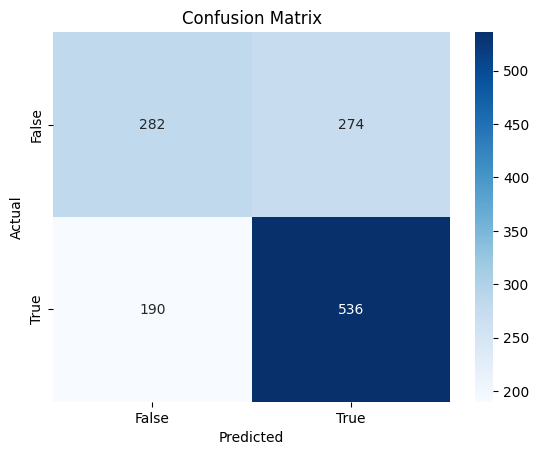

Elapsed time: 314.83507919311523 seconds


In [ ]:
#Test phase
model.eval()
loss_test, acc_test=0,0
nb_test_steps,nb_test_examples=0,0

# Tracking variables
predictions , true_labels = [], []

#Data evaluation per epoch
##Initialize validation inputs
test_data = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

for batch in test_dataloader:
   batch = tuple(t.to(device) for t in batch)
   #Unpack inputs from dataloader
   t_input_ids,t_input_mask,t_labels=batch

   #Do not store gradients here
   with torch.no_grad():
      outputs=model(t_input_ids,token_type_ids=None,attention_mask=t_input_mask)
   logits=outputs[0]
   logits = logits.detach().cpu().numpy()
   label_ids = t_labels.to('cpu').numpy()

   predictions.extend(np.argmax(logits, axis=1))  # Predicted class
   true_labels.extend(label_ids)  # True class
   test_accuracy_batch=flat_accuracy(logits,label_ids)
   acc_test+=test_accuracy_batch
   nb_test_steps+=1

#Report accuracy of validation run
print("Accuracy:{0:.8f}".format(acc_test/nb_test_steps))

print("\nClassification Report:")
print(classification_report(true_labels, predictions))
#custom_order = [4,1,2,0,3,5]

conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["False","True"], yticklabels=["False","True"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Code to be timed

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")


In [ ]:
"""def predict_single_statement(model, tokenizer, statement, device):
    model.eval()  # Set the model to evaluation mode

    # Tokenize and encode the statement
    encoded_dict = tokenizer.encode_plus(
        statement,
        add_special_tokens=True,
        max_length=100,  # Adjust as per your model's input requirements
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',  # Return PyTorch tensors
    )

    # Extract input IDs and attention masks
    input_ids_test = encoded_dict['input_ids'].to(device)
    attention_mask_test = encoded_dict['attention_mask'].to(device)

    # Perform the prediction
    with torch.no_grad():
        outputs = model(input_ids_test, token_type_ids=None, attention_mask=attention_mask_test)

    # Extract logits
    logits = outputs[0].detach().cpu().numpy()

    # Apply softmax for probabilities
    from torch.nn.functional import softmax
    probabilities = softmax(torch.tensor(logits), dim=1).numpy()

    # Get the predicted class
    predicted_class = probabilities.argmax(axis=1)[0]

    # Map to string label
    predicted_string_label = label_encoder_test.inverse_transform([predicted_class])[0]

    return predicted_class, probabilities, logits

# Example usage
statement = "The United States has a low voter turnout rate."
predicted_numeric_class, probabilities, logits = predict_single_statement(model, tokenizer, statement, device)

print(statement)
print(f"Predicted Numeric Class: {predicted_numeric_class}")
print(f"Probabilities: {probabilities}")
print(f"Logits: {logits}")
"""

'def predict_single_statement(model, tokenizer, statement, device):\n    model.eval()  # Set the model to evaluation mode\n\n    # Tokenize and encode the statement\n    encoded_dict = tokenizer.encode_plus(\n        statement,\n        add_special_tokens=True,\n        max_length=100,  # Adjust as per your model\'s input requirements\n        pad_to_max_length=True,\n        return_attention_mask=True,\n        return_tensors=\'pt\',  # Return PyTorch tensors\n    )\n\n    # Extract input IDs and attention masks\n    input_ids_test = encoded_dict[\'input_ids\'].to(device)\n    attention_mask_test = encoded_dict[\'attention_mask\'].to(device)\n\n    # Perform the prediction\n    with torch.no_grad():\n        outputs = model(input_ids_test, token_type_ids=None, attention_mask=attention_mask_test)\n\n    # Extract logits\n    logits = outputs[0].detach().cpu().numpy()\n\n    # Apply softmax for probabilities\n    from torch.nn.functional import softmax\n    probabilities = softmax(torch